In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    f1_score,
    auc,
)


sns.set(style="whitegrid")
sns.set_color_codes("pastel")

In [3]:
full_train = pd.read_csv("datasets/train_clean.csv")

to_drop = [
    "Name",
    "Ticket",
    "Embarked",
    "PassengerId",
    *[c for c in full_train if "cabin" in c.lower()],
]

full_train.drop(columns=to_drop, inplace=True)

target_col = "Survived"

X = full_train.drop(target_col, axis=1)
y = full_train[target_col]

X_train, y_train = X, y

model = BernoulliNB()

param_grid = {
    "alpha": [0.1, 0.5, 1.0, 2.0, 5.0],
    "fit_prior": [True, False],
}

grid_search = GridSearchCV(
    model, param_grid, n_jobs=1, cv=5, scoring="accuracy", verbose=4
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .........alpha=0.1, fit_prior=True;, score=0.798 total time=   0.0s
[CV 2/5] END .........alpha=0.1, fit_prior=True;, score=0.798 total time=   0.0s
[CV 3/5] END .........alpha=0.1, fit_prior=True;, score=0.787 total time=   0.0s
[CV 4/5] END .........alpha=0.1, fit_prior=True;, score=0.753 total time=   0.0s
[CV 5/5] END .........alpha=0.1, fit_prior=True;, score=0.774 total time=   0.0s
[CV 1/5] END ........alpha=0.1, fit_prior=False;, score=0.798 total time=   0.0s
[CV 2/5] END ........alpha=0.1, fit_prior=False;, score=0.798 total time=   0.0s
[CV 3/5] END ........alpha=0.1, fit_prior=False;, score=0.787 total time=   0.0s
[CV 4/5] END ........alpha=0.1, fit_prior=False;, score=0.753 total time=   0.0s
[CV 5/5] END ........alpha=0.1, fit_prior=False;, score=0.774 total time=   0.0s
[CV 1/5] END .........alpha=0.5, fit_prior=True;, score=0.798 total time=   0.0s
[CV 2/5] END .........alpha=0.5, fit_prior=True;

In [4]:
import joblib

joblib.dump(
    grid_search,
    f"../models/{grid_search.best_estimator_.__class__.__name__}_{grid_search.best_score_ * 100:.4f}.joblib",
)

['models/BernoulliNB_78.5139.joblib']

In [5]:
model_name = grid_search.estimator.__class__.__name__

get_best = True  # get the best model or the latest model

# get files in models sorted by last modified
if get_best:
    import os
    import re

    files = os.listdir("../models")
    files = [f for f in files if re.match(f"{model_name}_.*\.joblib", f)]
    files = sorted(
        files, key=lambda x: re.search(r"_(\d+\.\d+)\.joblib", x).group(1), reverse=True
    )
    file_name = files[0]
else:
    import os
    import re

    files = os.listdir("../models")
    files = [f for f in files if re.match(f"{model_name}_.*\.joblib", f)]
    files = sorted(
        files, key=lambda x: os.path.getmtime(os.path.join("models", x)), reverse=True
    )
    file_name = files[0]
loaded_grid_search = joblib.load(f"../models/{file_name}")

In [6]:
for k, v in loaded_grid_search.cv_results_.items():
    print(k, v, sep="\t")

mean_fit_time	[0.00200825 0.00195446 0.00312023 0.00447669 0.00192614 0.00189147
 0.00185447 0.00180221 0.00179257 0.00198765]
std_fit_time	[2.14781843e-04 1.28203201e-04 2.15552896e-03 4.56355002e-03
 7.51493546e-05 1.07009058e-04 3.05329969e-05 1.37631758e-05
 1.07891717e-05 2.08072712e-04]
mean_score_time	[0.00255857 0.00131311 0.00400085 0.0019134  0.00131783 0.0012805
 0.00125995 0.00125389 0.00123162 0.00128818]
std_score_time	[2.11368583e-03 4.66629929e-05 4.16976052e-03 9.42781992e-04
 3.41505300e-05 6.05352989e-05 1.38501291e-05 1.36348748e-05
 1.48903044e-05 3.80598504e-05]
param_alpha	[0.1 0.1 0.5 0.5 1.0 1.0 2.0 2.0 5.0 5.0]
param_fit_prior	[True False True False True False True False True False]
params	[{'alpha': 0.1, 'fit_prior': True}, {'alpha': 0.1, 'fit_prior': False}, {'alpha': 0.5, 'fit_prior': True}, {'alpha': 0.5, 'fit_prior': False}, {'alpha': 1.0, 'fit_prior': True}, {'alpha': 1.0, 'fit_prior': False}, {'alpha': 2.0, 'fit_prior': True}, {'alpha': 2.0, 'fit_prior'

In [7]:
real_test = pd.read_csv("datasets/test_clean.csv")

In [8]:
real_test.drop(columns=list(set(to_drop) - {"PassengerId"}), inplace=True)

In [9]:
pred = pd.DataFrame(best_model.predict(real_test.drop(columns=["PassengerId"]))).rename(
    columns={0: "Survived"}
)

In [10]:
# get probabilities
probs = best_model.predict_proba(X_train)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# predict class values
yhat = best_model.predict(X_train)

# calculate roc-auc score
lr_auc = roc_auc_score(y_train, probs)

# calculate roc curve
ns_fpr, ns_tpr, _ = roc_curve(y_train, probs)

# get f1 score
lr_f1 = f1_score(y_train, best_model.predict(X_train))

# get auc score
lr_auc = auc(ns_fpr, ns_tpr)

# get precision & recall
lr_precision, lr_recall, _ = precision_recall_curve(y_train, probs)

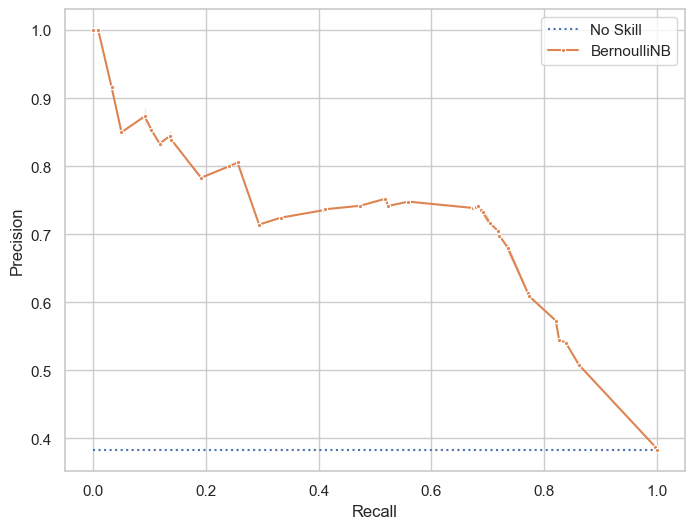

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get no-skill line
no_skill = len(y_train[y_train == 1]) / len(y_train)

# Set the style
sns.set(style="whitegrid")

# Plot the precision-recall curves
plt.figure(figsize=(8, 6))
sns.lineplot(x=[0, 1], y=[no_skill, no_skill], linestyle="dotted", label="No Skill")
sns.lineplot(x=lr_recall, y=lr_precision, marker=".", label=model_name)

# Set axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()

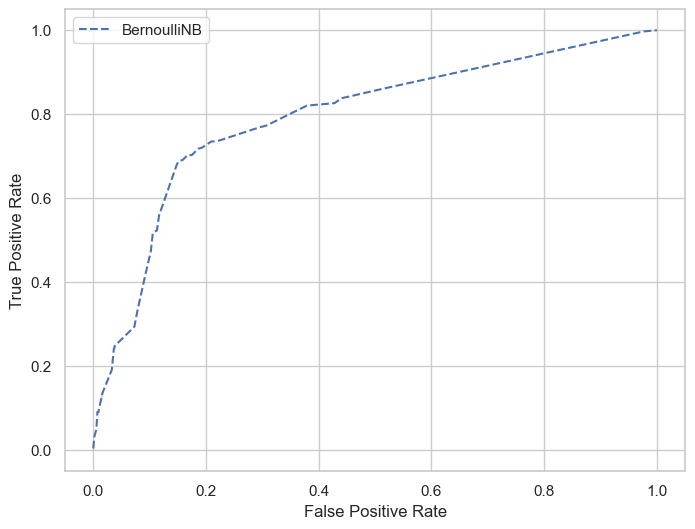

In [12]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=ns_fpr, y=ns_tpr, linestyle="--", label=model_name)

# Set axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [13]:
pd.concat([real_test[["PassengerId"]], pred], axis=1).to_csv(
    f"../outs/{best_model.__class__.__name__}_{grid_search.best_score_ * 100:.4f}.csv",
    index=False,
)